## SC4001 Neural Networks and Deep Learning

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Group Project

###
Students are to propose and execute a final project on an application or a research issue that is related to neural networks and deep learning. The project can be carried out in a group consisting of no more than three members. Students are to come up with a potential technique for the application or to mitigate the issue, to develop associated codes, and to compare with existing methods. Students may choose, focus, and expand on the project ideas A – F given below.

By the deadline, students are to submit a project report in a .pdf file of ten A4 pages (Arial 10 font) and associated code in a .zip file to NTULearn.

The project report should have the names of the team members on the front page and contain an introduction to the project idea, a review of existing techniques, a description of the methods used, experiments and results, and a discussion. The 10-page limit is exclusive of references, content page, and cover page. The code needs to be commented properly. Make sure the code can be tested easily.

The assessment is based on the project execution (30%), experiments and results (30%), report presentation (15%), and novelty (15%), and peer review (10%. Conducted via Eureka). We apply the same late submission penalty as in Assignment 1, i.e., 5% for each day up to three days.

---

### Topic F. Flowers Recognition
###
The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set. The training set and validation set each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 6149 images (minimum 20 per class). Some tasks to consider:

1.	Modify some previously published architectures e.g., increase the network depth, reducing their parameters, etc. Explore more advanced techniques such as [deformable convolution](https://pytorch.org/vision/main/generated/torchvision.ops.deform_conv2d.html), [dilated convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) (dilation>1) or [visual prompt](https://github.com/KMnP/vpt) tuning for Transformers.
2.	Analyze the results of using fewer training images, i.e., few-shot learning
3.	Use more advanced transformation techniques such as MixUp (see the [original paper](https://arxiv.org/abs/1710.09412) and its PyTorch implementation [here](https://pytorch.org/vision/master/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py))
4.	Try more advanced loss function such as triplet loss

References:
1.
Nilsback, M-E. and Zisserman, A., “Automated flower classification over a large number of
classes,” in British Machine Vision Conference (BMVC), 2008


Datasets:
1. The dataset is available in TorchVision
https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html
2. The Oxford Flowers 102 Dataset https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

---

### Importing Essential PyTorch and torchvision Libraries

Import various libraries and modules from PyTorch and torchvision that are essential for neural network training and data processing.

---

### CUDA Deep Neural Network Library (`cudnn`)

- **`import torch.backends.cudnn as cudnn`**:
    - `cudnn` is a GPU-accelerated library for deep neural networks. It provides highly tuned implementations for standard routines such as forward and backward convolution, pooling, normalization, and activation layers.
    - Leveraging `cudnn` can lead to significant speedups in training and inference when using NVIDIA GPUs.

### torchvision Library
####
- **`import torchvision`**:
    - `torchvision` is a library that consists of popular datasets, model architectures, and common image transformations for computer vision.

- **Datasets (`datasets`)**:
    - **`from torchvision import datasets`**:
        - This module provides access to various standard datasets like CIFAR-10, MNIST, etc., making it easier to load and preprocess data.

- **Pre-trained Models (`models`)**:
    - **`from torchvision import models`**:
        - This module provides definitions for popular model architectures like ResNet, VGG, and AlexNet. It also offers pre-trained models, which can be used for transfer learning.

- **Image Transformations (`transforms`)**:
    - **`from torchvision import transforms`**:
        - This module offers common image transformations like normalization, cropping, and augmentation. These transformations are essential for preprocessing data before feeding it into neural networks.

By importing these libraries and modules, we equip ourselves with the tools necessary for various stages of deep learning, from data preprocessing to model training and evaluation.

In [1]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.ops import DeformConv2d	# Deformable Convolution

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import requests
from tempfile import TemporaryDirectory

cudnn.benchmark = True

# Check the version of PyTorch
print(torch.__version__)

2.6.0+cu124


### Set Seed:
- `seed = 10; torch.manual_seed(seed)`: These lines set the seed for generating random numbers. Setting a seed ensures that the random numbers generated are predictable and reproducible. In this case, the seed is set to 10.


In [2]:
# for reproducibility
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

### Data Augmentation, Normalization, and Loading

Preparing the dataset for training and validation by applying necessary transformations, augmentations, and normalization. Additionally, it sets up dataloaders for efficient data feeding into the neural network.

### Data Transformations (`data_transforms`)

- **Training Data**:
    1. **RandomResizedCrop**: Randomly crops the image to size 224x224. This not only helps in resizing the images but also provides a form of data augmentation.
    2. **RandomHorizontalFlip**: Randomly flips the image horizontally, providing another form of data augmentation.
    3. **ToTensor**: Converts the PIL Image to a PyTorch tensor.
    4. **Normalize**: Normalizes the tensor with the provided mean and standard deviation values. These values are often pre-computed from large datasets like ImageNet.

- **Validation Data**:
    1. **Resize**: Resizes the shortest side of the image to 256 while maintaining the aspect ratio.
    2. **CenterCrop**: Crops the center of the image to 224x224.
    3. **ToTensor** and **Normalize**: Same as the training data transformations.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Load the Oxford Flowers 102 dataset

#### Dataset Directory (`data_dir`)

- Specifies the directory where the dataset is located.

#### Datasets (`datasets`)

- **`from torchvision import datasets`**:
        - This module provides access to various standard datasets like FLOWERS102, etc., making it easier to load and preprocess data.

#### Dataloaders (`dataloaders`)

- Sets up dataloaders for both training and validation data.
    - **batch_size**: Number of samples per batch.
    - **shuffle**: Shuffles the dataset before each epoch for the training set.
	- **num_workers**: Number of subprocesses to use for data loading. Helps in parallelizing the data loading task.

In [4]:
# Load the Oxford Flowers 102 dataset
data_dir = "./data"
train_dataset = datasets.Flowers102(root=data_dir, split='train', download=True, transform=data_transforms['train'])
val_dataset   = datasets.Flowers102(root=data_dir, split='val',   download=True, transform=data_transforms['val'])
test_dataset  = datasets.Flowers102(root=data_dir, split='test',  download=True, transform=data_transforms['test'])

# Create data loaders
# num_workers=0 tested best for setup
# pin_memory helps boosts CPU -> GPU transfers
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

100%|██████████| 345M/345M [00:21<00:00, 16.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 926kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 20.1MB/s]


In [5]:
# Verify the data
print(f"Train      dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test       dataset size: {len(test_dataset)}")

Train      dataset size: 1020
Validation dataset size: 1020
Test       dataset size: 6149


### Device Setup (`device`)

- Determines if a CUDA-compatible GPU is available. If so, sets the device to "cuda:0", otherwise defaults to the CPU ("cpu").

In [6]:
# Device Setup
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"  # macbook uses metal performance shaders to GPU accelearation
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Visualize a few images
Let's visualize a few training images so as to understand the data augmentations.

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))	# convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean					# reverse the normalization
    inp  = np.clip(inp, 0, 1)				# clip value to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=12)  		# Set title size
    plt.axis('off')  						# turn off axis to make it cleaner
    plt.pause(0.001)  						# pause a bit so that plots are updated

### Load a Batch and Select a Sample:
- `dataiter = iter (train_loader); inputs, classes = next(dataiter)`: This line loads a batch of images and corresponding classes from the `train_loader`. The `next` function retrieves the next item from the iterator created by `iter(train_loader)`. This will be a batch of images and their corresponding labels. Since `train_loader` shuffles the data at every epoch, this will effectively be a random batch.

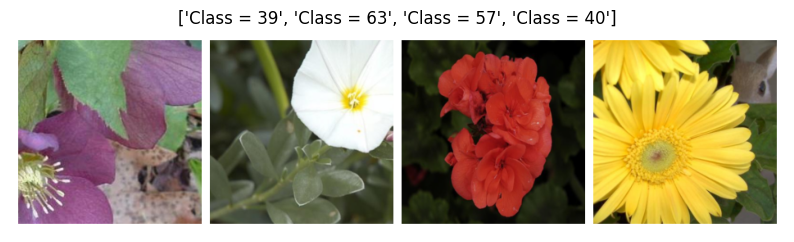

In [8]:
# Get some random training images
dataiter        = iter(train_loader)
inputs, classes = next(dataiter)

# Display some images
out = torchvision.utils.make_grid(inputs[:4], nrow=4, padding=10, pad_value=255)

# Increase figure size
plt.figure(figsize=(10, 10))

imshow(out, title=[f"Class = {class_}" for class_ in classes[:4]])
plt.show()

### Training and evaluating the model

The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

### Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset

#### Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training, validation and evaluation**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - Running statistics like loss and accuracy are computed for each epoch.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

In [9]:
# Training function
def train_loop(dataloader, model, criterion, optimizer, scheduler):
    size = len(dataloader.dataset)		# Dataset size
    train_loss = 0.0
    train_acc  = 0

    running_loss = 0.0
    running_acc  = 0

    model.train()
    # Iterate over data
    for inputs, labels in dataloader:	# Batch loop
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Backpropagation
        optimizer.zero_grad()			# Zero the parameter gradients

        outputs  = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss     = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_acc  += torch.sum(preds == labels.data)

    scheduler.step()  					# Learning rate scheduler step

    train_loss = running_loss / size
    train_acc  = running_acc.double() / size
    return train_loss, train_acc

In [10]:
# Validation/test function
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)	# Dataset size
    test_loss = 0.0
    test_acc  = 0

    running_loss = 0.0
    running_acc  = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs  = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss     = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_acc  += torch.sum(preds == labels.data)

    test_loss = running_loss / size
    test_acc  = running_acc.double() / size
    return test_loss, test_acc

In [11]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience	# number of epochs to wait if no improvement and then stop the training
        self.min_delta = min_delta	# a minimum increase in the score to qualify as an improvement
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
def train_and_evaluate(model, criterion, optimizer, scheduler, num_epochs=100):
	since = time.time()

	# Create a temporary directory to save training checkpoints
	with TemporaryDirectory() as tempdir:
		best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

		torch.save(model.state_dict(), best_model_params_path)
		best_acc = 0.0

		early_stopper = EarlyStopper(patience=10, min_delta=0)

		tr_loss, tr_acc = [], []
		vl_loss, vl_acc = [], []

		for epoch in range(num_epochs):	# epoch loop
			train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer, scheduler)
			val_loss,   val_acc   = test_loop(val_loader, model, criterion)

			tr_loss.append(train_loss), tr_acc.append(train_acc)
			vl_loss.append(val_loss),   vl_acc.append(val_acc)

			print(f"Epoch {epoch+1:2d}: Train_accuracy: {(100*train_acc):>5.2f}%, Train_loss: {train_loss:.4f}, "
				  f"Validation_accuracy: {(100*val_acc):>5.2f}%, Validation_loss: {val_loss:.4f}")

			if val_acc > best_acc:
				best_acc = val_acc
				torch.save(model.state_dict(), best_model_params_path)

			if early_stopper.early_stop(val_loss):
				print(f"Early stopping triggered at epoch {epoch+1}!")
				break

		time_elapsed = time.time() - since
		print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
		print(f'Best Validation Accuracy: {best_acc * 100:.2f}%')

        # load best model weights
		model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
	return model, tr_loss, tr_acc, vl_loss, vl_acc

### Deformable Convolution

####
Deformable convolution is an advanced variant of standard convolution that adaptively adjusts its receptive field by learning spatial offsets for each sampling location. This allows the network to focus on more relevant regions of the input, which is especially useful for:

•	Fine-grained recognition (e.g., flowers with subtle differences)

•	Non-rigid object deformation (e.g., bent petals, occlusions)

•	Irregular shapes (common in natural images)

In [13]:
# Define the DeformableBlock (used later in layer3[0].conv2)
class DeformableBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.offsets = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size,
                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        self.deform = DeformConv2d(in_channels, out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        offset = self.offsets(x)
        x = self.deform(x, offset)
        x = self.bn(x)
        return self.relu(x)


### Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer. More models are available at https://pytorch.org/vision/stable/models.html

In this section, we configure a ResNet-18 model for the task, set up the loss function, and define the optimizer and learning rate scheduler.

### Model Configuration (`model_ft`)

1. **Load Pre-trained ResNet-18**:
    - `models.resnet18(weights='IMAGENET1K_V1')`: Loads the ResNet-18 model pre-trained on the ImageNet dataset.

2. **Modify Fully Connected Layer**:
    - The final fully connected layer of ResNet-18 is modified to match the number of classes in our dataset.
    - `model_ft.fc.in_features`: Fetches the number of input features to the fully connected layer.

3. **Transfer Model to Device**:
    - `model_ft.to(device)`: Moves the model to the specified device (either CPU or GPU).

### Loss Function (`criterion`)

- **CrossEntropyLoss (`nn.CrossEntropyLoss()`)**:
    - A commonly used loss function for classification tasks.
    - It combines the log softmax and negative log likelihood loss.

### Optimizer (`optimizer_ft`)

- **Stochastic Gradient Descent (SGD)**:
    - Parameters:
        - **model_ft.parameters()**: All the trainable parameters of the model.
        - **lr=0.001**: Learning rate.
        - **momentum=0.9**: Momentum factor.

### Learning Rate Scheduler (`exp_lr_scheduler`)

- **StepLR**:
    - Adjusts the learning rate based on the number of epochs.
    - Parameters:
        - **optimizer_ft**: The optimizer whose learning rate needs to be adjusted.
        - **step_size=7**: The learning rate is decayed every 7 epochs.
        - **gamma=0.1**: The factor by which the learning rate is decayed.

In [14]:
# Load pretrained ResNet18
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace a deeper convolution (e.g., layer3[0].conv2) with deformable conv
original_layer = model_ft.layer3[0].conv2
in_channels = original_layer.in_channels
out_channels = original_layer.out_channels
kernel_size = original_layer.kernel_size[0]
stride = original_layer.stride[0]
padding = original_layer.padding[0]

model_ft.layer3[0].conv2 = DeformableBlock(in_channels, out_channels,
                                           kernel_size=kernel_size, stride=stride, padding=padding)

# Replace final FC layer for 102 flower classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)
model_ft = model_ft.to(device)

# Optional: Freeze early layers for stability
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3[0].conv2.parameters():
    param.requires_grad = True
for param in model_ft.fc.parameters():
    param.requires_grad = True

# Criterion and optimizer with lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()),
                         lr=0.005, momentum=0.9)

# LR Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


### Train and evaluate

In [15]:
# Train and evaluate
model_ft, tr_loss, tr_acc, vl_loss, vl_acc = train_and_evaluate(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100
)

Epoch  1: Train_accuracy:  2.55%, Train_loss: 4.6376, Validation_accuracy:  1.76%, Validation_loss: 4.6889
Epoch  2: Train_accuracy: 15.88%, Train_loss: 3.9235, Validation_accuracy: 32.84%, Validation_loss: 3.2416
Epoch  3: Train_accuracy: 36.47%, Train_loss: 3.1050, Validation_accuracy: 46.57%, Validation_loss: 2.5297
Epoch  4: Train_accuracy: 50.59%, Train_loss: 2.4457, Validation_accuracy: 56.86%, Validation_loss: 2.0641
Epoch  5: Train_accuracy: 58.63%, Train_loss: 2.0069, Validation_accuracy: 61.76%, Validation_loss: 1.7177
Epoch  6: Train_accuracy: 69.41%, Train_loss: 1.6144, Validation_accuracy: 66.57%, Validation_loss: 1.5034
Epoch  7: Train_accuracy: 75.10%, Train_loss: 1.3979, Validation_accuracy: 70.00%, Validation_loss: 1.3554
Epoch  8: Train_accuracy: 80.78%, Train_loss: 1.1377, Validation_accuracy: 72.45%, Validation_loss: 1.2580
Epoch  9: Train_accuracy: 81.57%, Train_loss: 1.0817, Validation_accuracy: 73.14%, Validation_loss: 1.2308
Epoch 10: Train_accuracy: 81.47%, Tra

### Observation

####
The results suggest deformable convolution, as currently implemented, improved significantly in terms of the training time and convergence for this specific task compared to standard convolution. However, if the validation accuracy is the main priority, the standard ResNet-18 model performs much better on this task.

### Plot the learning curves

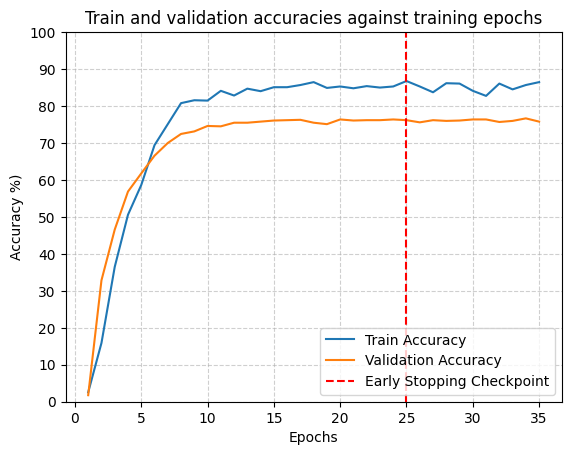

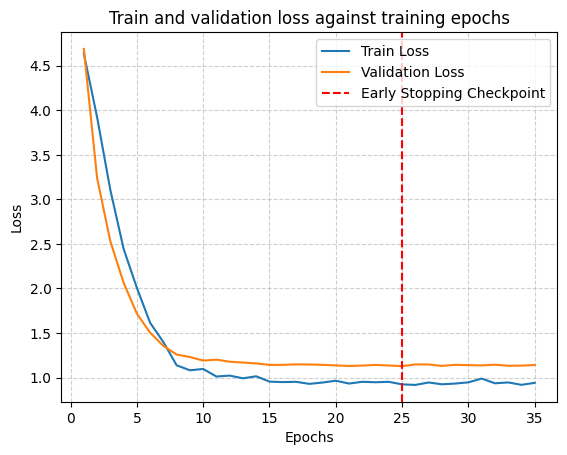

In [16]:
# Plot train and validation accuracies against training epochs
plt.figure(1)
plt.clf()
plt.plot(range(1, len(tr_acc) + 1), [acc.cpu().numpy() * 100 for acc in tr_acc], label='Train Accuracy')
plt.plot(range(1, len(vl_acc) + 1), [acc.cpu().numpy() * 100 for acc in vl_acc], label='Validation Accuracy')

# Find position of lowest validation loss
minposs = vl_loss.index(min(vl_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Accuracy %)')
plt.title ('Train and validation accuracies against training epochs')
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot train and validation loss against training epochs
fig = plt.figure(2)
plt.plot(range(1,len(tr_loss)+1), tr_loss, label='Train Loss')
plt.plot(range(1,len(vl_loss)+1), vl_loss, label='Validation Loss')

# Find position of lowest validation loss
minposs = vl_loss.index(min(vl_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title ('Train and validation loss against training epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Test evaluation

In [17]:
# Test evaluation
print("Running final test evaluation...")
since = time.time()
test_loss, test_acc = test_loop(test_loader, model_ft, criterion)
time_elapsed = time.time() - since

print(f"Final Test Accuracy: {(100*test_acc):>5.2f}%, Test Loss: {test_loss:.4f}")
print(f'Test evaluation completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Running final test evaluation...
Final Test Accuracy: 73.15%, Test Loss: 1.2533
Test evaluation completed in 0m 45s


### Visualizing the model predictions

The `visualize_model` function is designed to display predictions of the provided model on images from the validation dataset.

### Parameters:

- **model**: The trained neural network model whose predictions are to be visualized.
- **num_images**: The number of images on which predictions are to be displayed (default is 6).

### Process:

1. **Model State**:
    - The current training state of the model (either training or evaluation) is stored in the `was_training` variable.

2. **Set Model to Evaluation Mode**:
    - The model is set to evaluation mode using `model.eval()`. This ensures that operations like dropout are not applied during inference.

3. **Image Counter**:
    - `images_so_far` keeps track of the number of images processed.

4. **Visualization Setup**:
    - A new matplotlib figure is initialized to display the images and their predictions.

5. **Iterate Over Validation Data**:
    - The function iterates over batches of images from the validation dataset.
    - For each batch:
        - The images and labels are transferred to the appropriate device (either CPU or GPU).
        - The model makes predictions on the batch of images.
        - The predicted class indices are extracted using `torch.max`.

6. **Display Predictions**:
    - For each image in the batch:
        - A subplot is created for the image.
        - The image is displayed along with its predicted class label.
        - If the number of images displayed reaches `num_images`, the function returns.

7. **Restore Model State**:
    - Before exiting the function, the model's training state is restored to its original value using `model.train(mode=was_training)`.

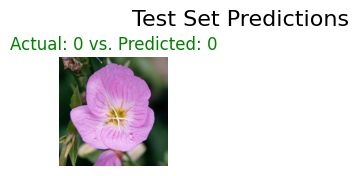

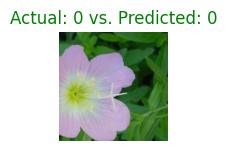

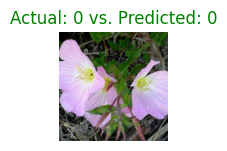

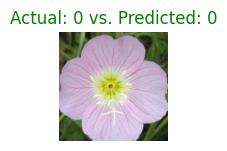

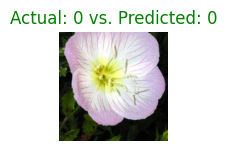

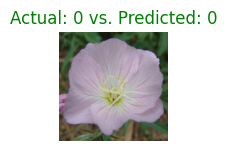

In [18]:
# Visualize test set predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    plt.suptitle("Test Set Predictions", fontsize=16)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

				# Highlight incorrect predictions in red
                title_color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(
                    f'Actual: {labels[j].item()} vs. Predicted: {preds[j].item()}',
                    color=title_color,
                )

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)
plt.show()

### Observation

####
All the 6 images are correctly classified.

## ConvNet as fixed feature extractor

Here, we need to freeze all layers that are pretrained ResNet18 except deformable block (to learn) and the final layer (for classfication). We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.

In [20]:
# Load pretrained ResNet18
model_conv = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Unfreeze conv1 with DeformableBlock
# to allow new DeformableBlock to adapt to the flower dataset
model_conv.conv1 = DeformableBlock(3, 64, kernel_size=7, stride=2, padding=3)

# Unfreeze DeformableBlock parameters
for param in model_conv.conv1.parameters():
    param.requires_grad = True

# Unfreeze final classification layer
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 102)

# Move to device
model_conv = model_conv.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Only optimize unfrozen layers: DeformableBlock + fc
trainable_params = list(model_conv.conv1.parameters()) + list(model_conv.fc.parameters())
optimizer_conv = optim.SGD(trainable_params, lr=0.005, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [21]:
# Train and evaluate
model_conv, tr_loss_, tr_acc_, vl_loss_, vl_acc_ = train_and_evaluate(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100
)

Epoch  1: Train_accuracy:  1.67%, Train_loss: 4.7869, Validation_accuracy:  2.75%, Validation_loss: 4.5652
Epoch  2: Train_accuracy:  5.49%, Train_loss: 4.4237, Validation_accuracy: 10.98%, Validation_loss: 4.1236
Epoch  3: Train_accuracy: 11.76%, Train_loss: 4.0291, Validation_accuracy: 18.43%, Validation_loss: 3.7785
Epoch  4: Train_accuracy: 19.41%, Train_loss: 3.6959, Validation_accuracy: 22.94%, Validation_loss: 3.4910
Epoch  5: Train_accuracy: 25.88%, Train_loss: 3.3714, Validation_accuracy: 28.82%, Validation_loss: 3.3072
Epoch  6: Train_accuracy: 31.96%, Train_loss: 3.1405, Validation_accuracy: 33.04%, Validation_loss: 3.0838
Epoch  7: Train_accuracy: 35.59%, Train_loss: 2.9391, Validation_accuracy: 35.59%, Validation_loss: 2.8982
Epoch  8: Train_accuracy: 42.35%, Train_loss: 2.7213, Validation_accuracy: 38.73%, Validation_loss: 2.8050
Epoch  9: Train_accuracy: 47.55%, Train_loss: 2.6390, Validation_accuracy: 39.90%, Validation_loss: 2.7534
Epoch 10: Train_accuracy: 49.90%, Tra

### Observation

####
The results suggest that deformable convolutions do not improve the flower recognition performance.  The added complexity of deformable convolutions may make the optimization problem more challenging, leading to reduced accuracy and longer training times.

### Plot the learning curves

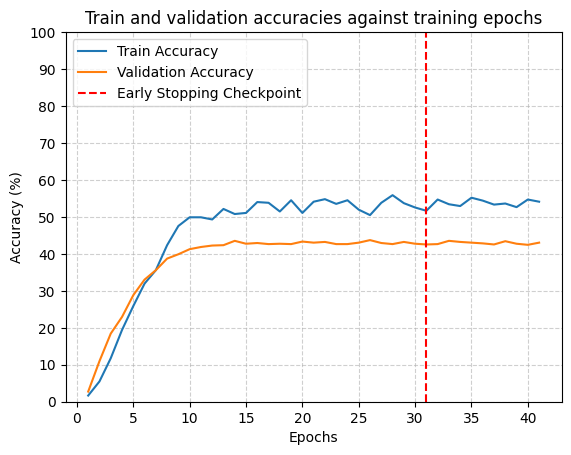

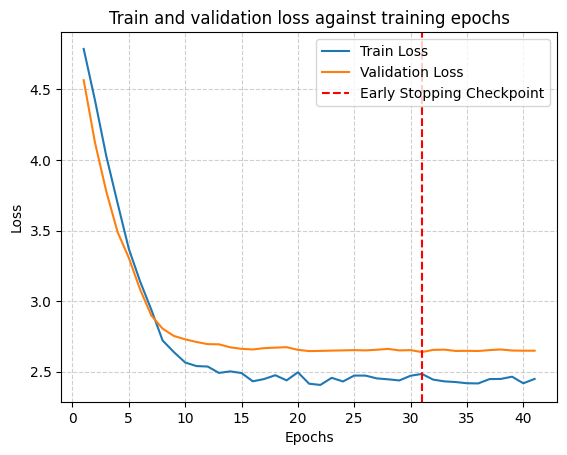

In [22]:
# Plot train and validation accuracies against training epochs
plt.figure(3)
plt.clf()
plt.plot(range(1, len(tr_acc_) + 1), [acc.cpu().numpy() * 100 for acc in tr_acc_], label='Train Accuracy')
plt.plot(range(1, len(vl_acc_) + 1), [acc.cpu().numpy() * 100 for acc in vl_acc_], label='Validation Accuracy')

# Find position of lowest test loss
minposs = vl_loss_.index(min(vl_loss_))+1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title ('Train and validation accuracies against training epochs')
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot train and validation loss against training epochs
fig = plt.figure(4)
plt.plot(range(1,len(tr_loss_)+1), tr_loss_, label='Train Loss')
plt.plot(range(1,len(vl_loss_)+1), vl_loss_, label='Validation Loss')

# Find position of lowest test loss
minposs = vl_loss_.index(min(vl_loss_))+1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title ('Train and validation loss against training epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [23]:
# Test evaluation
print("Running final test evaluation...")
since = time.time()
test_loss, test_acc = test_loop(test_loader, model_conv, criterion)
time_elapsed = time.time() - since

print(f"Final Test Accuracy: {(100*test_acc):>5.2f}%, Test Loss: {test_loss:.4f}")
print(f'Test evaluation completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Running final test evaluation...
Final Test Accuracy: 39.76%, Test Loss: 2.8060
Test evaluation completed in 0m 49s


### Observations

The model without deformable convolution significantly outperforms the model with deformable convolution on the test set. The deformable convolution model's test accuracy is much lower, and the test loss is much higher, indicating poor generalization to unseen data..

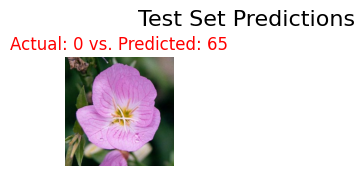

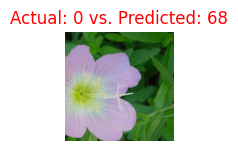

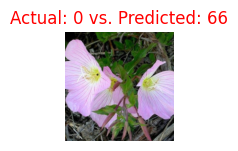

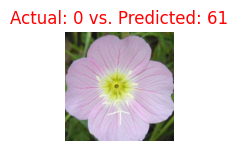

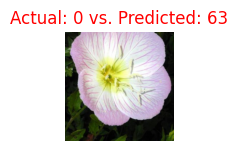

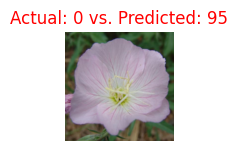

In [24]:
visualize_model(model_conv)
plt.show()

### Observation

####
The model is unable to classify the test images.
